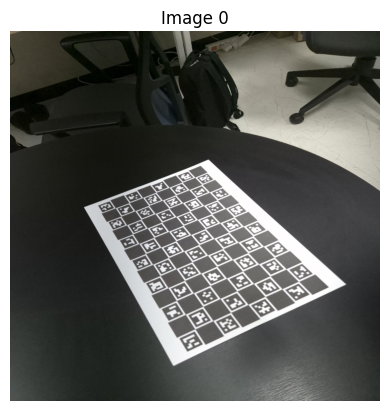

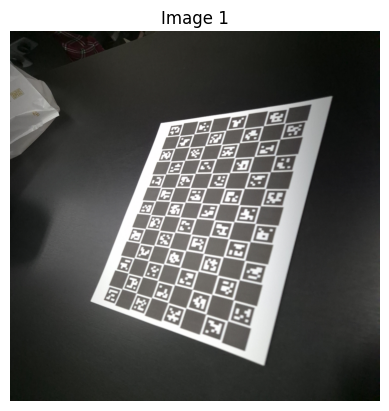

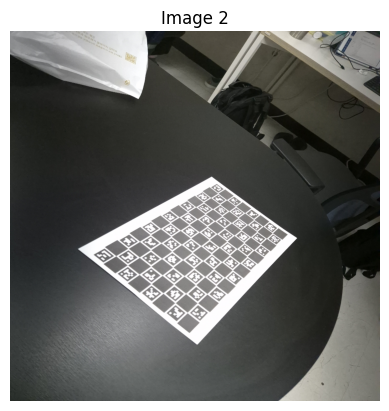

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Step 1: 이미지 로드 및 표시
def load_images(folder):
    paths = sorted(glob.glob(os.path.join(folder, "*.jpg")))
    images = [cv2.resize(cv2.imread(p), (1024, 1024)) for p in paths]
    return images

# 예제 실행
images = load_images('./camera_image3_f0.6')
for i, img in enumerate(images[:3]):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()

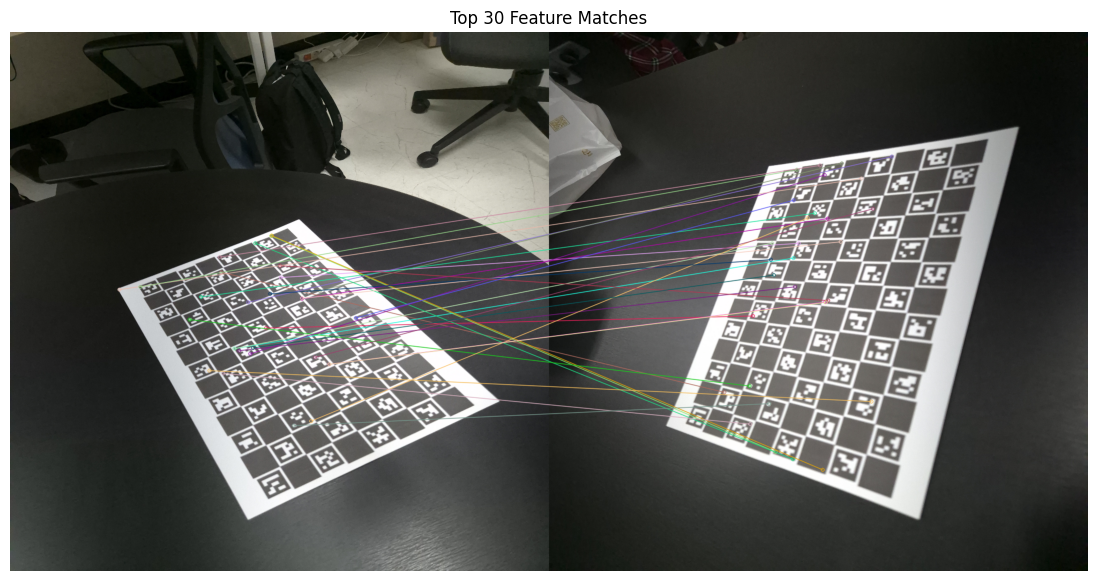

In [2]:
def extract_and_match(img1, img2):
    orb = cv2.ORB_create(1000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good[:30], None, flags=2)
    plt.figure(figsize=(14,7))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title("Top 30 Feature Matches")
    plt.axis('off')
    plt.show()

    return kp1, kp2, good

# 예제 실행
kp1, kp2, good = extract_and_match(images[0], images[1])

In [3]:
def estimate_homography(kp1, kp2, matches):
    src = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC)
    return H

# 예제 실행
H = estimate_homography(kp1, kp2, good)
print("Estimated Homography H:\n", H)

Estimated Homography H:
 [[-9.42736187e-01 -9.06027771e-02  3.05031379e+02]
 [-1.13207973e+00 -2.36113420e+00  1.85918241e+03]
 [-5.39208605e-04 -2.04540228e-03  1.00000000e+00]]


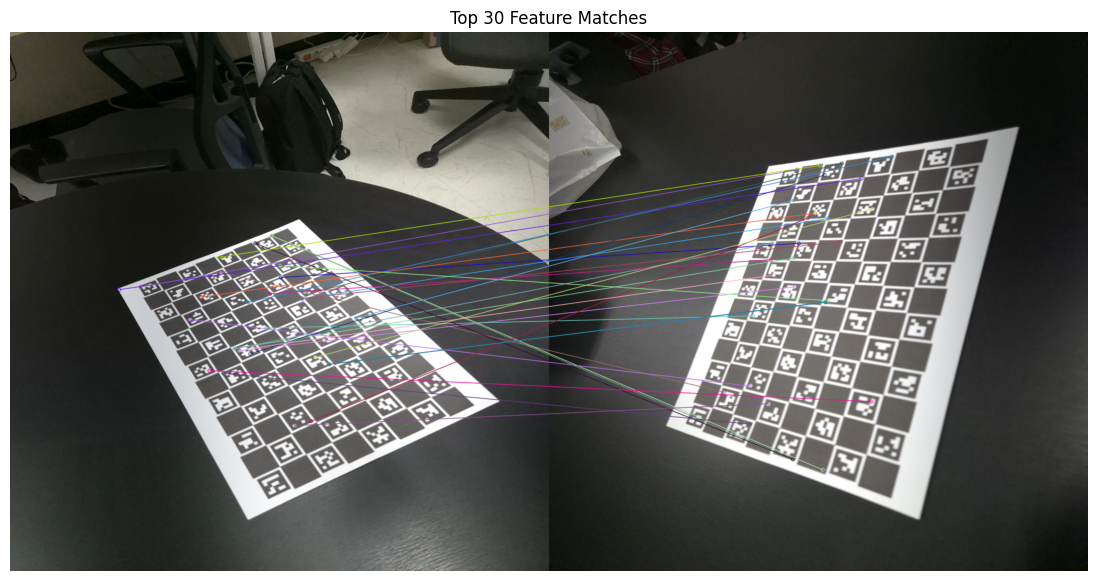

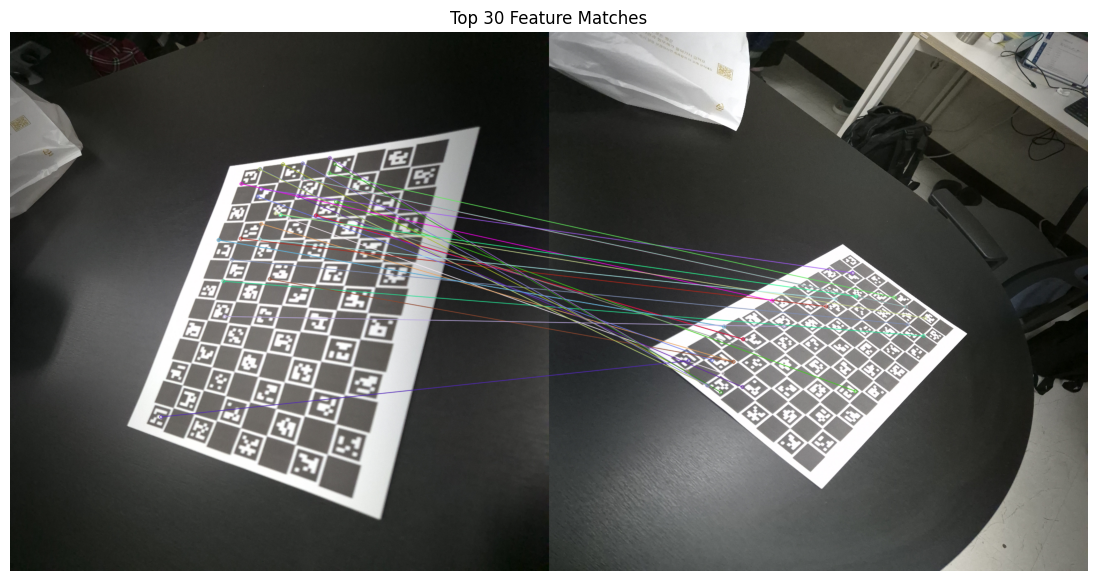

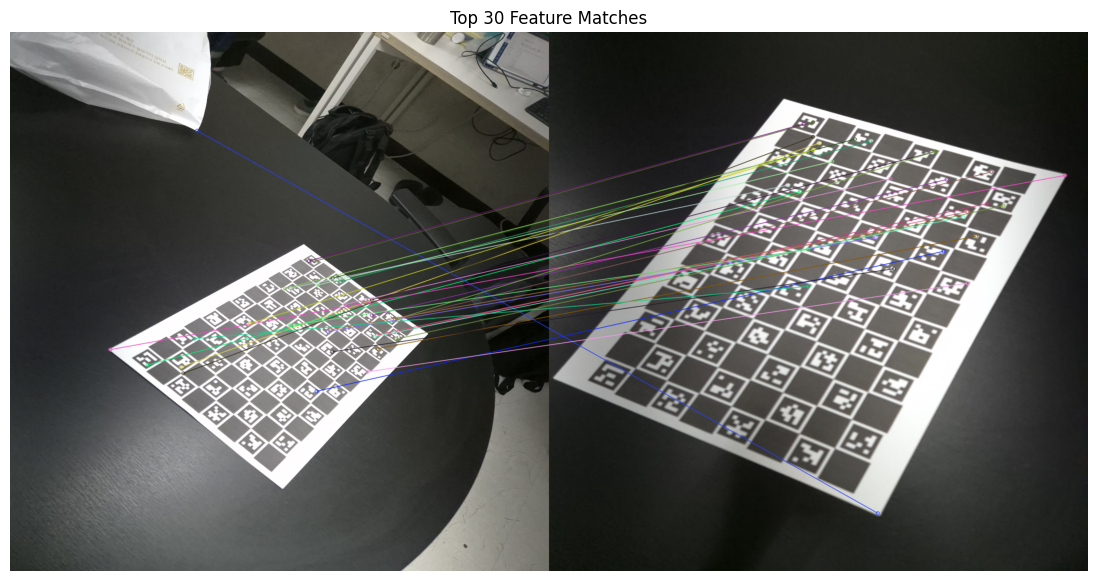

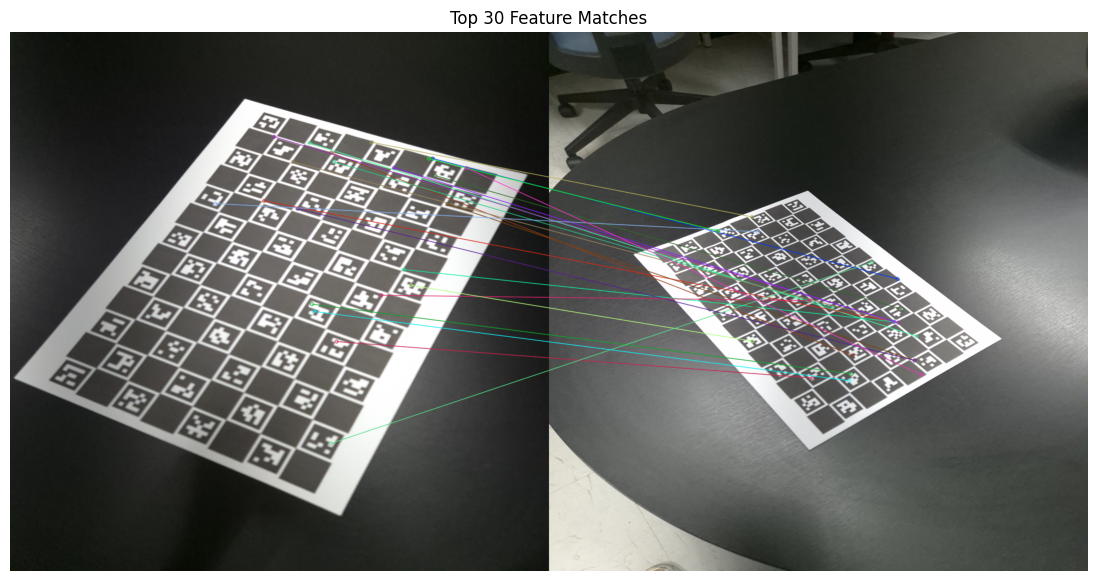


📷 Estimated Intrinsic Matrix K:
[[         nan          nan          nan]
 [  0.                  nan 763.52834253]
 [  0.           0.           1.        ]]


/var/folders/00/g8qdvht528xc9srh5br0f6jc0000gn/T/ipykernel_14540/876930648.py:43: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(lam / b[0])
/var/folders/00/g8qdvht528xc9srh5br0f6jc0000gn/T/ipykernel_14540/876930648.py:44: RuntimeWarning: invalid value encountered in sqrt
  beta = np.sqrt(lam * b[0] / (b[0]*b[2] - b[1]**2))


In [4]:
import cv2
import numpy as np
import glob
import os

def compute_intrinsics(homographies):
    V = []
    for H in homographies:
        h1, h2 = H[:, 0], H[:, 1]
        v12 = np.array([
            h1[0]*h2[0],
            h1[0]*h2[1] + h1[1]*h2[0],
            h1[1]*h2[1],
            h1[2]*h2[0] + h1[0]*h2[2],
            h1[2]*h2[1] + h1[1]*h2[2],
            h1[2]*h2[2]
        ])
        v11 = np.array([
            h1[0]*h1[0],
            h1[0]*h1[1] + h1[1]*h1[0],
            h1[1]*h1[1],
            h1[2]*h1[0] + h1[0]*h1[2],
            h1[2]*h1[1] + h1[1]*h1[2],
            h1[2]*h1[2]
        ])
        v22 = np.array([
            h2[0]*h2[0],
            h2[0]*h2[1] + h2[1]*h2[0],
            h2[1]*h2[1],
            h2[2]*h2[0] + h2[0]*h2[2],
            h2[2]*h2[1] + h2[1]*h2[2],
            h2[2]*h2[2]
        ])
        V.append(v12)
        V.append(v11 - v22)

    V = np.array(V)
    _, _, VT = np.linalg.svd(V)
    b = VT[-1]

    v0 = (b[1]*b[3] - b[0]*b[4]) / (b[0]*b[2] - b[1]**2)
    lam = b[5] - (b[3]**2 + v0*(b[1]*b[3] - b[0]*b[4])) / b[0]
    alpha = np.sqrt(lam / b[0])
    beta = np.sqrt(lam * b[0] / (b[0]*b[2] - b[1]**2))
    gamma = -b[1]*alpha**2 * beta / lam
    u0 = gamma*v0 / beta - b[3]*alpha**2 / lam

    K = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])
    return K

# === 실행 ===
folder = "./camera_image"
images = load_images(folder)
homographies = []
for i in range(len(images)-1):
    kp1, kp2, matches = extract_and_match(images[i], images[i+1])
    H = estimate_homography(kp1, kp2, matches)
    if H is not None:
        homographies.append(H)

if len(homographies) >= 3:
    K = compute_intrinsics(homographies)
    print("\n📷 Estimated Intrinsic Matrix K:")
    print(K)
else:
    print("❌ 유효한 Homography가 3개 이상 필요합니다.")